In [9]:
import torch
import numpy as np
import pandas as pd
import librosa as lr
import matplotlib.pyplot as plt

from librosa import display as lrd
import IPython.display as ipd

from torch.utils.data import DataLoader, ConcatDataset, random_split
from asteroid.data import TimitDataset
from tqdm import tqdm

from torch import optim
from torch_lr_finder import LRFinder
from pytorch_lightning import Trainer, loggers as pl_loggers
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from asteroid_filterbanks.transforms import mag
from asteroid.engine import System
from asteroid.losses import singlesrc_neg_sisdr

from asteroid import DCUNet, DCCRNet

def sisdr_loss_wrapper(est_target, target):
    return singlesrc_neg_sisdr(est_target.squeeze(1), target).mean()

def show_wav(wav, sr=16000):
    if type(wav) == str:
        wav, sr = lr.load(wav)
    elif type(wav) == torch.Tensor:
        wav = wav.detach().numpy()
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    lrd.waveplot(wav, sr=sr, ax=axes[0])
    
    S_db = lr.amplitude_to_db(np.abs(lr.stft(wav)))
    img = lrd.specshow(S_db, sr=sr, ax=axes[1])
    fig.colorbar(img, ax=axes[1])
    
    fig.tight_layout()
    plt.show()
    ipd.display(ipd.Audio(wav, rate=sr))

def train_val_split(ds, val_fraction=0.1, random_seed=42):
    assert val_fraction > 0 and val_fraction < 0.5
    len_train = int(len(ds) * (1 - val_fraction))
    len_val = len(ds) - len_train
    return random_split(ds, [len_train, len_val], generator=torch.Generator().manual_seed(random_seed))
    
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
TIMIT_CACHE_DIR = '/import/vision-eddydata/dm005_tmp/mixed_wavs_asteroid'
ds25 = TimitDataset('../../../datasets/TIMIT', '../../../datasets/noises-train-drones',
    cache_dir=TIMIT_CACHE_DIR, snr=-25, random_seed=42, mixtures_per_clean=5,
    dset_name='train-drones', subset='train', track_duration=48000)

In [15]:
train, val = train_val_split(ds25)
train_loader = DataLoader(train, shuffle=True, batch_size=32, num_workers=5, drop_last=True)
val_loader = DataLoader(val, batch_size=32, num_workers=5, drop_last=True)

In [16]:
dcunet20 = DCUNet("DCUNet-20", fix_length_mode="trim")
dcunet20_opt = optim.Adam(dcunet20.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(dcunet20_opt, patience=3)
early_stopping = EarlyStopping(monitor='val_loss', patience=6)
system = System(dcunet20, dcunet20_opt, sisdr_loss_wrapper, train_loader, val_loader, scheduler)

In [17]:
logger = pl_loggers.TensorBoardLogger('logs', name='TIMIT-drones-DCUNET-20-m25db-only', version=1)
trainer = Trainer(gpus=-1, accelerator='dp', logger=logger, callbacks=[early_stopping])

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


In [18]:
trainer.fit(system)


  | Name  | Type   | Params
---------------------------------
0 | model | DCUNet | 3.5 M 
---------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params


/homes/dm005/conda_env/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: `training_step` must be implemented to be used with the Lightning Trainer
  warnings.warn(*args, **kwargs)
/homes/dm005/conda_env/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


1

In [21]:
dcunet20_25_serialized = dcunet20.serialize()
torch.save(dcunet20_25_serialized, 'dcunet20_25db_v1.pt')

In [22]:
mix, clean = ds25[2]

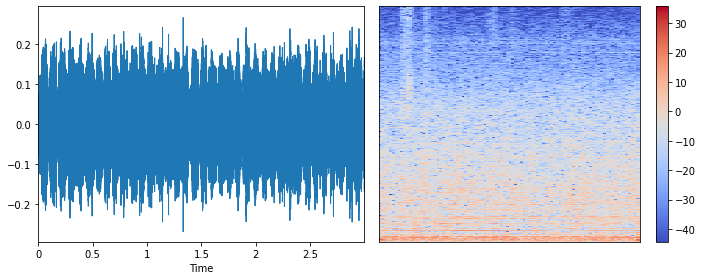

In [23]:
show_wav(mix)

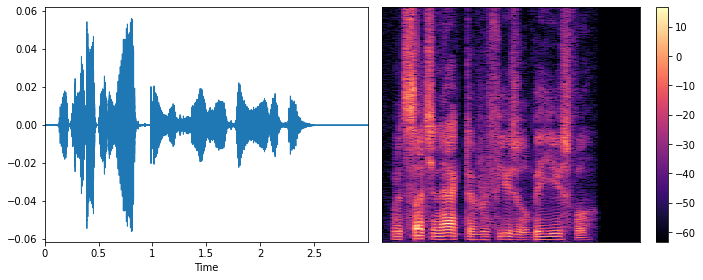

In [24]:
show_wav(clean)

In [25]:
enh = dcunet20(mix).flatten()

In [ ]:
show_wav(enh)